<a href="https://colab.research.google.com/github/TravisHunting/BinaryClassification/blob/master/DenseBinaryClassifier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTANT**

To use the checkpoint file trained on 75000 mugshots and 75000 celebrity images, run only the steps that start with **"[CHECKPOINT#]"**

Download test data (do not bother with this step if you are downloading the checkpoint)

In [ ]:
!wget --no-check-certificate \
    https://github.com/TravisHunting/BinaryClassification/blob/master/train.zip?raw=true \
    -O /tmp/train.zip

**[CHECKPOINT1]** Download the checkpoint

In [ ]:
!mkdir /tmp/save
#!pip install gdown
!gdown https://drive.google.com/uc?id=1YLxZsnUOEVBzKv66mou5PmtI_Td0NOn9   #download checkpoint

mkdir: cannot create directory ‘/tmp/save’: File exists
Downloading...
From: https://drive.google.com/uc?id=1YLxZsnUOEVBzKv66mou5PmtI_Td0NOn9
To: /content/checkpoint.zip
85.6MB [00:00, 88.6MB/s]


**[CHECKPOINT2]** Unzip the checkpoint (If you download and use the checkpoint you don't need to train the model or load test data)

In [ ]:
import os
import zipfile

local_zip = '/content/checkpoint.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/save')

zip_ref.close()

Unzip test data (once again, skip if using the checkpoint)

In [ ]:
import os
import zipfile

local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

zip_ref.close()


Split test data into validation/test splits and create file lists (skip if using checkpoint)

In [ ]:
import shutil
import random

!mkdir /tmp/valid
!mkdir /tmp/valid/mugshots
!mkdir /tmp/valid/celebrities

# Directory with our training mugshots
train_mugshots_dir = os.path.join('/tmp/train/mugshots')
train_mugshots_names = os.listdir(train_mugshots_dir)

# Directory with our training celeb pictures
train_celebrities_dir = os.path.join('/tmp/train/celebrities')
train_celebrities_names = os.listdir(train_celebrities_dir)

# Directory with our validation mugshots
valid_mugshots_dir = os.path.join('/tmp/valid/mugshots')

# Directory with our validation celeb pictures
valid_celebrities_dir = os.path.join('/tmp/valid/celebrities')

print(train_mugshots_names)

mugshot_val = random.sample(train_mugshots_names, 10000)  #select validation images randomly from test images
celeb_val = random.sample(train_celebrities_names, 10000) #select validation images randomly from test images

for f in mugshot_val:
    shutil.move(train_mugshots_dir+'/'+f, valid_mugshots_dir)

for f in celeb_val:
    shutil.move(train_celebrities_dir+'/'+f, valid_celebrities_dir)

validation_mugshots_names = os.listdir(valid_mugshots_dir)
print(validation_mugshots_names)

validation_celebrities_names = os.listdir(valid_celebrities_dir)
print(validation_celebrities_names)


Print out some information about training and validation data

In [ ]:
print('total training mugshot images:', len(os.listdir(train_mugshots_dir)))
print('total training celeb images:', len(os.listdir(train_celebrities_dir)))
print('total validation mugshot images:', len(os.listdir(valid_mugshots_dir)))
print('total validation celeb images:', len(os.listdir(valid_celebrities_dir)))

**[CHECKPOINT3]** **Run this regardless of checkpoint usage.** Import plt

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Display some of the test data

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_mugshots_pic = [os.path.join(train_mugshots_dir, fname) 
                for fname in train_mugshots_names[pic_index-8:pic_index]]
next_celebrities_pic = [os.path.join(train_celebrities_dir, fname) 
                for fname in train_celebrities_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_mugshots_pic + next_celebrities_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Extract data from your image sets

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/train/',  # This is the source directory for training images
        classes = ['mugshots', 'celebrities'],
        target_size=(100, 100),  # All images will be resized to 100x100
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/valid/',  # This is the source directory for training images
        classes = ['mugshots', 'celebrities'],
        target_size=(100, 100),  # All images will be resized to 100x100
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

**[CHECKPOINT4]** **Run this regardless of checkpoint usage.** Import the various things you need to create the model.

In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

**[CHECKPOINT5]** **Run this regardless of checkpoint usage.** Define the model.

If using the checkpoint, model must be

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (100,100,3)), 
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (100,100,3)), 
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

**Optional.** Display some info about the model.

In [ ]:
model.summary()

**[CHECKPOINT6]** **Run this regardless of checkpoint usage.** Compile the model.

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

**[CHECKPOINT7]** Load the checkpoint that was downloaded earlier

In [ ]:
model.load_weights('/tmp/save/my_checkpoint')  #If you have a saved TF checkpoint, load it here and skip training below

Train and evaluate the model (skip if using checkpoint file)

In [ ]:
history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

In [ ]:
model.evaluate(validation_generator)

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**[CHECKPOINT8]** **Run this regardless of checkpoint usage.** Upload your own images and find out whether you look more like a celebrity, or more like a criminal. Run as many times as you like. After clicking "Run" scroll down a bit to use the "upload files" box. If no faces are detected, the image will be skipped. If faces are detected, each face will be pulled out and evaluated separately.

Saving 462.jpg to 462.jpg

Number of faces detected:  2

462.jpg
 You are a beautiful celebrity.


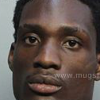

462.jpg
 You are a filthy criminal.


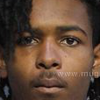

In [28]:
#!mkdir uploads 
 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
import cv2
import requests
from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
 
face_grab = requests.get('https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml')
 
with open('haar_cascade.xml', 'wb') as f:   #uncomment this section the first time you run the colab notebook to download the haarcascade
  f.write(face_grab.content)
 
face_cascade = cv2.CascadeClassifier('/content/haar_cascade.xml')
 
uploaded = files.upload()
#print(uploaded.keys())
print()
 
for fn in uploaded.keys(): 
 
  path = '/content/' + fn
  path2 = '/content/uploads/'
  img = cv2.imread(path)
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) 
  #Lower scaleFactor for more detailed searching, Raise minNeighbors for more selective searching. 
  #Do the opposite for easier face detection (can cause false positives)
  image1 = Image.open(path)
 
  if len(faces) == 0:
    print(fn)
    print('No faces detected.')
    continue
 
  if len(faces) >= 1:
    print("Number of faces detected: ",len(faces))
    print()
    face_list = []
    
    for (x,y,w,h) in faces:
      image_res = image1.crop((x,y,x+w,y+h)) #crop the faces out of the image
      face_list.append(image_res.resize((100,100)))  #resize each image of a face to 100x100 square and collect into a list
    #print(type(image_res)) 
  
  for img in face_list:
    x = image.img_to_array(img)
    #plt.imshow(x/255.)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    #print("classification value: ",classes[0])
    if classes[0]<0.5:
      print(fn + "\n You are a filthy criminal.")
    else:
      print(fn + "\n You are a beautiful celebrity.")
    display(img)

The next code block will create a checkpoint for you if you have been training your own model.

In [ ]:
!mkdir /tmp/save
model.save_weights('/tmp/save/my_checkpoint') # Save the weights for your model so you don't have to train it next time

Next code block kills the instance. Run when you are done if you feel like being subservient to your overlords at google.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)